In [1]:
import functools
import torch
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

/home/emiliia/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/emiliia/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/emiliia/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Загрузка данных
df_train = pd.read_csv("files_rtf.csv")
df_test = pd.read_csv('sample.csv').dropna()
df_resh = pd.read_csv("resh.csv")

# Объединение датасетов
df_combined = pd.concat([df_train, df_test, df_resh], ignore_index=True)

# Перемешивание данных
df_combined = df_combined.sample(frac=1, random_state=777).reset_index(drop=True)

# Инициализация и применение LabelEncoder
label_encoder = LabelEncoder()
df_combined['class'] = label_encoder.fit_transform(df_combined['class'])
df_combined['text'] = df_combined['text'].astype(str)

train_df, temp_df = train_test_split(df_combined, test_size=0.3, random_state=777)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=777)

# Создание датасетов для Hugging Face's datasets library
train_ds = Dataset.from_dict({'text': train_df['text'], 'class': train_df['class']})
val_ds = Dataset.from_dict({'text': val_df['text'], 'class': val_df['class']})
test_ds = Dataset.from_dict({'text': test_df['text'], 'class': test_df['class']})
datasets = DatasetDict({'train': train_ds, 'val': val_ds, 'test': test_ds})

In [3]:
# Загрузка токенизатора и модели
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Функция токенизации
def tokenize_examples(examples, tokenizer):
    tokenized_inputs = tokenizer(examples['text'], max_length=512, padding="max_length", truncation=True)
    tokenized_inputs['labels'] = examples['class']
    return tokenized_inputs

# Токенизация датасетов
tokenized_datasets = datasets.map(functools.partial(tokenize_examples, tokenizer=tokenizer), batched=True)
tokenized_datasets = tokenized_datasets.with_format('torch')

# Загрузка модели
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(df_combined['class'])))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Map:   0%|          | 0/847 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [4]:
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    decoded_predictions = label_encoder.inverse_transform(predictions)
    labels = p.label_ids
    decoded_labels = label_encoder.inverse_transform(labels)
    f1_weighted = f1_score(decoded_labels, decoded_predictions, average='weighted')
    return {'f1_weighted': f1_weighted}

In [6]:
# значения на видеокарту с 12ГБ
per_device_train_batch_size = 8
per_device_eval_batch_size = 16

In [5]:
# значения на видеокарту с 16ГБ
per_device_train_batch_size = 16
per_device_eval_batch_size = 32

In [7]:
import numpy as np
from transformers import Trainer, TrainingArguments, TrainerCallback

class EarlyStoppingCallback(TrainerCallback):
    """Колбэк для ранней остановки обучения."""
    def __init__(self, early_stopping_patience: int = 3, early_stopping_threshold: float = 0.0):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_threshold = early_stopping_threshold
        self.best_metric = None
        self.patience_counter = 0

    def on_evaluate(self, args, state, control, **kwargs):
        # Получаем последнее значение метрики
        eval_metric = kwargs['metrics']['eval_f1_weighted']
        
        if self.best_metric is None or eval_metric > self.best_metric + self.early_stopping_threshold:
            self.best_metric = eval_metric
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= self.early_stopping_patience:
            print("No improvement in metrics for {} evaluations, stopping training.".format(self.early_stopping_patience))
            control.should_training_stop = True

# Настройка параметров обучения
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-05,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    num_train_epochs=15,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1_weighted',
    greater_is_better=True
)

# Инициализация тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['val'],
    compute_metrics=lambda p: {"f1_weighted": f1_score(p.label_ids, np.argmax(p.predictions, axis=1), average='weighted')},
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)]
)

# Начало тренировки модели
trainer.train()

/home/emiliia/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1 Weighted
1,No log,1.192948,0.567005
2,No log,0.621901,0.808980
3,No log,0.338923,0.945749
4,No log,0.178479,0.977455
5,0.643300,0.123408,0.967812
6,0.643300,0.076174,0.983216


Checkpoint destination directory ./results/checkpoint-106 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-212 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-318 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-424 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-530 already exists and is non-empty.Saving will proceed but saved results may be invalid.


No improvement in metrics for 2 evaluations, stopping training.


Checkpoint destination directory ./results/checkpoint-636 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=636, training_loss=0.5145252808085028, metrics={'train_runtime': 236.4352, 'train_samples_per_second': 53.736, 'train_steps_per_second': 6.725, 'total_flos': 1337238433327104.0, 'train_loss': 0.5145252808085028, 'epoch': 6.0})

In [8]:
# Выполнение предсказаний на тестовом датасете
test_results = trainer.predict(tokenized_datasets['test'])

# Получение предсказанных меток и реальных меток
predictions = np.argmax(test_results.predictions, axis=-1)
true_labels = test_results.label_ids

# Вычисление метрик
test_f1_weighted = f1_score(true_labels, predictions, average='weighted')
print(f"F1-Score (Weighted) on Test Set: {test_f1_weighted}")

F1-Score (Weighted) on Test Set: 0.9666270439701927


In [9]:
# Выполнение предсказаний на тестовом датасете, если это еще не сделано
test_results = trainer.predict(tokenized_datasets['test'])
predictions = np.argmax(test_results.predictions, axis=-1)
true_labels = test_results.label_ids

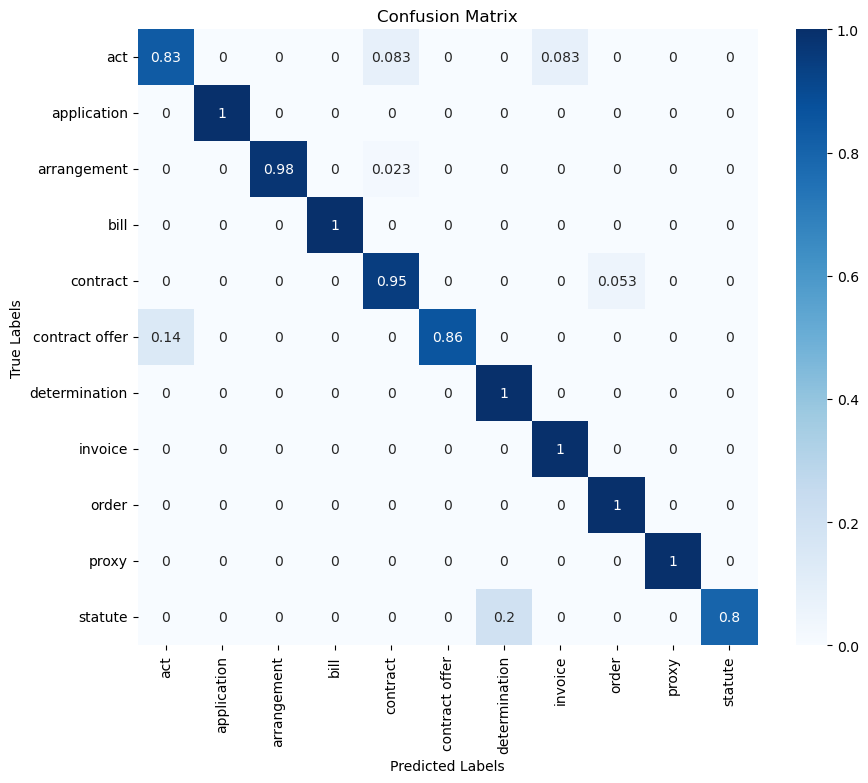

In [10]:
# Создание матрицы ошибок
conf_matrix = confusion_matrix(true_labels, predictions, normalize='true')

# Визуализация матрицы ошибок
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Вывод отчета по классификации
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

                precision    recall  f1-score   support

           act       0.91      0.83      0.87        12
   application       1.00      1.00      1.00         5
   arrangement       1.00      0.98      0.99        44
          bill       1.00      1.00      1.00         3
      contract       0.90      0.95      0.92        19
contract offer       1.00      0.86      0.92         7
 determination       0.92      1.00      0.96        11
       invoice       0.90      1.00      0.95         9
         order       0.98      1.00      0.99        54
         proxy       1.00      1.00      1.00        13
       statute       1.00      0.80      0.89         5

      accuracy                           0.97       182
     macro avg       0.96      0.95      0.95       182
  weighted avg       0.97      0.97      0.97       182



In [13]:
label2id = {k: v for v, k in enumerate(label_encoder.classes_)}
id2label = {y:x for x,y in label2id.items()}
trainer.model.config.label2id = label2id
trainer.model.config.id2label = id2label
trainer.model.config.id2label

{0: 'act',
 1: 'application',
 2: 'arrangement',
 3: 'bill',
 4: 'contract',
 5: 'contract offer',
 6: 'determination',
 7: 'invoice',
 8: 'order',
 9: 'proxy',
 10: 'statute'}

In [14]:
model_path = "./best_model"
trainer.model.save_pretrained(model_path)
trainer.tokenizer.save_pretrained(model_path)

('./best_model/tokenizer_config.json',
 './best_model/special_tokens_map.json',
 './best_model/vocab.txt',
 './best_model/added_tokens.json',
 './best_model/tokenizer.json')